# ADA Project

Now that we understand the dataset, we are going to try to answer our research questions in this notebook.

In [12]:
import pandas as pd
import time
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
# read the dataframes
all_games = pd.read_pickle("data/games.pkl")
all_orders = pd.read_pickle("data/orders.pkl")
all_players = pd.read_pickle("data/players.pkl")
all_turns = pd.read_pickle("data/turns.pkl")
all_units = pd.read_pickle("data/units.pkl")

# remove duplicates
all_units = all_units.drop_duplicates()

# Descriptive statistics

We look at the **outcome** (binary) considering the **treatment**, which can be:
- engaged: player who was engaged in a friendship
- single: player who was not engaged in a friendship

And for engaged player, there is an aditional treatment: 
- betrayer: player who betrayed another one
- betrayed: player who ended up betrayed by another
- neutral: player who was not engaged in a *broken* friendship

In order to answer this question, let's define a few functions that we will use in the later analysis.

In [4]:
countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
pairs = [x+y for x in countries for y in countries if y > x]

In [5]:
def get_engageds(friendships):
    """Returns the players engaged in a friendship"""
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    return list(set(''.join(cols)))

def get_singles(engageds):
    """Returns players not engaged in a friendship"""
    singles = countries.copy()
    for engaged in engageds:
        singles.remove(engaged)
    return singles

In [6]:
def get_betrayers_and_betrayed(friendships):
    """Given the Friendships dataframe as defined in our analysis, returns all the players who commited 
    betrayals and all players who ended up betrayed"""
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    betrayers = []
    betrayeds = []
    for c in cols: 
        tmp = friendships[c]
        values = tmp[tmp != 0].values
        if type(values[-1]) == str: 
            betrayer = values[-1]
            betrayers.append(betrayer)
            tmp = list(c)
            tmp.remove(betrayer)
            betrayeds.append(tmp[0])
            
    return betrayers, betrayeds

def get_neutrals(betrayers, betrayeds):
    """Given betrayers and betrayeds players of a game, returns the list of players
    who were not involved in a broken friendship
    
    Required: player must be 'engaged'
    """
    neutrals = countries.copy()
    for b in betrayers: 
        if b in neutrals: neutrals.remove(b)
    for b in betrayeds: 
        if b in neutrals: neutrals.remove(b)
    return neutrals

In [7]:
def get_winners(game_id):
    winner = all_players.query("game_id == @game_id & won == 1")
    return winner.country.values

def get_losers(winners):
    loosers = countries.copy()
    for w in winners: loosers.remove(w)
    return loosers

In [8]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)
verbose = False

data_overall = np.zeros(shape = (2,2))
data_engaged = np.zeros(shape = (3,2))

treatments_overall = ["single", "engaged"]
treatments_engaged = ["betrayer", "betrayed", "neutral"]
outcomes = ["winner", "loser"]

stats_overall = pd.DataFrame(data_overall, index = treatments_overall, columns = outcomes )
stats_engageds = pd.DataFrame(data_engaged, index = treatments_engaged, columns = outcomes )

N = len(games_id)
for i, game_id in enumerate(games_id):
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
    
    # get outcomes
    winners = get_winners(game_id)
    losers = get_losers(winners)
    
    # get treatment 1 
    engageds = get_engageds(friendships)
    singles = get_singles(engageds)
    
    # get treatment 2
    betrayers, betrayeds = get_betrayers_and_betrayed(friendships)
    neutrals = get_neutrals(betrayers, betrayeds)
    
    # overal statistics
    for w in winners:
        if w in singles: stats_overall.loc["single", "winner"] += 1
        if w in engageds: stats_overall.loc["engaged", "winner"] += 1
    for l in losers:
        if l in singles: stats_overall.loc["single", "loser"] += 1
        if l in engageds: stats_overall.loc["engaged", "loser"] += 1
    
    # statistics about betrayers: 
    for winner in winners: 
        if winner in engageds: 
            if winner in betrayers: stats_engageds.loc["betrayer", "winner"] += 1
            if winner in betrayeds: stats_engageds.loc["betrayed", "winner"] += 1
            if winner in neutrals: stats_engageds.loc["neutral", "winner"] += 1
    for loser in losers: 
        if winner in engageds:
            if loser in betrayers: stats_engageds.loc["betrayer", "loser"] += 1
            if loser in betrayeds: stats_engageds.loc["betrayed", "loser"] += 1
            if loser in neutrals: stats_engageds.loc["neutral", "loser"] += 1
            
    if verbose:
        print("\nGame",i)
        print("Winners: ", winners, " and Losers", losers)
        print("Betrayers: ", betrayers, " and Betrayed", betrayeds)
        print("Neutrals: ", neutrals)



In [9]:
win_ratio = stats_overall.winner / (stats_overall.loser + stats_overall.winner)
stats_overall["win_ratio"] = win_ratio
print("Statistics over all dataset")
stats_overall

Statistics over all dataset


,winner,loser,win_ratio
single,186.0,1947.0,0.087201
engaged,371.0,996.0,0.271397


In [10]:
win_ratio = stats_engageds.winner / (stats_engageds.loser + stats_engageds.winner)
stats_engageds["win_ratio"] = win_ratio
print("Statistics over players engaged in a friendship")
stats_engageds

Statistics over players engaged in a friendship


,winner,loser,win_ratio
betrayer,133.0,126.0,0.513514
betrayed,70.0,189.0,0.270270
neutral,171.0,1610.0,0.096013


What can we see here ? 
- among all players that were involved in a broken friendship (either *betrayer* or *betrayed*) the chances of winning go towards the betrayer. Betrayed players have much higher chances of loosing and about 5 times less chances of winning. . .. 
- the neutral players represents the majority of players, however their chances of winning are not much bigger than the chances of win than betrayed people. 

These results make us strongly believe that **betrayals strongly influence the outcome of the game**. 

What can we do next ? 

- select 250 games with  and without betrayals (and all with friendships), then do a matching based on the games properties, and look at what differs once a betrayal happened for the players who were engaged in a friendship !

- quantify agressivity of players towards others, and using the same dataset as before, try to see what happens to a player that was betrayed

# Machine Learning Analysis: can we predict betrayals using game features ? 

We want to perform a logistic regression with our collected features.

In [ ]:
import statsmodels.formula.api as smf

features = pd.read_pickle("data/features_B200_V0_N1/features.pkl")
features.head(2)

In [ ]:
# 1. Normalisation 
predictors = ["length", "n_aoh_x", "n_aoh_y","n_aos_x", "n_aos_y", "supports_xy", "supports_yx"]
features = features[predictors + ["outcome"]]

def normalise_preds(features, predictors):
    for p in predictors: 
        features[p] = (features[p] - features[p].mean()) / features[p].std()
        
normalise_preds(features, predictors)

In [ ]:
# 2. Create the regression formula
formula = "outcome ~ " + ' + '.join(predictors)
formula

In [ ]:
# 3. Make the regression
mod = smf.logit(formula = formula, data = features)
res = mod.fit()
print(res.summary())

## Classification Assessment

Now that we have fitted a regression model, it is quite hard to interpret the summary. However, we can use additional metrics to see if our model is doing anything like we want to it.

It was for this purpose that we generated another set of points: the testing dataset.

Let's also focus our attention on the seasons where a real betrayal happened, and let's see if this classifier worked properly. It is for this reason that we test the results on the seasons of the testing set with betrayal.

In [ ]:
# 1. read the test dataset
features_test = pd.read_pickle("data/features_B20_V0_N1/features.pkl")

# normalise_preds(features_test, predictors)

X_test = features_test.query("outcome == 1")[predictors]
y_test = features_test.query("outcome == 1")["outcome"]

# 2. predict values and get the binary output
predictions = res.predict(X_test)
binaries = predictions.values.round()
binaries

The first metric we can look at is the [accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

In [ ]:
# 2. accuracy score
accuracy_score(y_test, binaries)

We see that we obtain about 45% of accuracy. Is this good ? Well, it is possible to compare this result with a **dummy estimator** to see if our models performs better than stupid ones. Here, there are several possibilities.
- The 'dumbest' estimator will perform better than this one. Indeed, guessing uniformly between either zero or one will give a 50% chance level to detect betrayals, when only trying to detect betrayals. So when looking dumbly at this task, it looks like what we have isn't good. However, such a result isn't so useful: indeed, there is a strong imbalance in the class labels and if a classifier says that only 50% of seasons are betrayal, it's a really bad. The reason it performs better here is because we selected only seasons where a betrayal happened.
- Another 'dummy' estimator is a stratified one: it generates random predictions by respecting the training set class distribution. We using this one, we obtain a classification score of 10%, which is now a lot less than what was obtained with our predictor.

In [ ]:
# 3. dummy estimator for sanity check
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='stratified', random_state=0)
X_train = features[predictors]
y_train = features["outcome"]

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

We can try to understand more using the confusion matrix. Here, betrayals are marked as negatives. The rows represent the actual classes (first row means no betrayal, second row means betrayal) and the columns represent the predicted class (first row means predicted as no betrayals, second row means predicted as betrayal).

In [ ]:
from sklearn.metrics import (confusion_matrix, accuracy_score, plot_confusion_matrix) 
m = confusion_matrix(y_test, binaries)
m

With our predictor, about 45% of betrayals are detected as so. One could think that this information is not enough for proclaming "good classifier", because what matters isn't only the 'True Betrayer' but also what happens to the seasons leading to a betrayer (i.e., what about 'False Betrayal' and 'True No Betrayal'. To investigate this result, one can run our previous analysis again without looking only at seasons where betrayal happened.

In [ ]:
X_test = features_test[predictors]
y_test = features_test["outcome"]

# 2. predict values and get the binary output
predictions = res.predict(X_test)
binaries = predictions.values.round()
accuracy_score(y_test, binaries)

In [ ]:
clf = DummyClassifier(strategy='stratified', random_state=0)
X_train = features[predictors]
y_train = features["outcome"]

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
m = confusion_matrix(y_test, binaries)
m

What do we observe ? The predictor has an overall accuracy of 67%: **this is better than random guess, however it is less than a most-frequent choice** (which guess based on the class distribution, and hence is garuanted to have a much higher accuracy since there is a strong class imbalance). Again, because of the **strong class imbalance**, the accuracy isn't enough to determine, but we can look at the confusion matrix. Again, for this matrix, 'Betrayer' is marked as 'Negatif'.
- The second column of $C$ is same as before, revealing that accuracy of detecting betrayer is about 45%. 
- The first column shows that $306 / 446 \approx 0.69 \%$ of non betrayals seasons are classifed as so, meaning that there are actually quite some seasons that are detected as betrayal when they are not. 

**TODO: talk about the results of the paper here!**

Like in what the paper did, we can ask ourself this question: **is it the case because some betrayals are detected too early ?**. Another question that we ask is **is it possible that more than one betrayals are detected within each game, and if so, how can we enforce that there's only one betrayal per game ?**

The first thing to do is to try to look at the results per games, using our training set. Then we can look at one game and see what's hapenning.

In [ ]:
# add the predicted outcome
features_test["outcome_pred"] = binaries
features_test.query("game_id == 52531.0")

# Plots

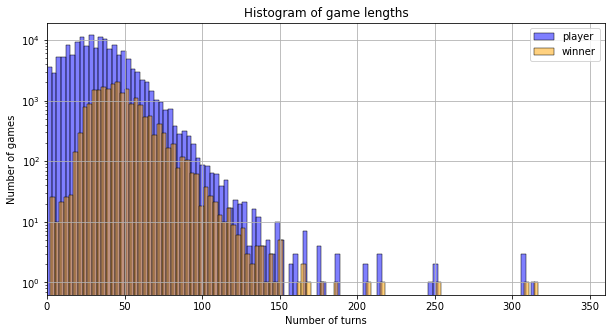

In [39]:
# HIstogram of game lengths for the average player and for the winner
plt.figure(figsize=(10,5))                             
winner_game_lengths =  all_players.sort_values('end_turn', ascending=False).drop_duplicates(['game_id'])
game_lengths = all_players.end_turn - all_players.start_turn

sns.histplot(game_lengths,
             alpha=0.5, 
             binwidth=3,
             color="blue")
sns.histplot(winner_game_lengths["end_turn"], 
             alpha=0.5, 
             binwidth=3, 
             color = "orange")


plt.title("Histogram of game lengths")
plt.xlabel("Number of turns")
plt.ylabel("Number of games")
plt.yscale("log")
plt.xlim(0,360 )
plt.grid(True)
plt.legend(["player","winner"])
plt.show()
